# <b>TrackML/HotelRank</b>: Elevating Revenue Performance Through Machine Learning and Deep Learning Techniques.

Revenue management is a very important to make profits in the hotel industry, three main factors play an important role to get it right:  
    <ol>
    <li>Hotel room demand over time (demand forecast).</li>
    <li>Prediction of booking cancellations.</li>
    <li>Online hotel reputation.</li>
    </ol>
In this project we take in account each one thru a linear combination of different scores that represent each item. For customer requirement we give factors 1.5 to Hotel room demand, 0.8 to prediction of booking cancellations, 0.5 to online reputation. We'll adjust at the end comparing with the effective revenue per Hotel.

# <b>DemandScore</b>: Demand Forecast over 12 months booking.

The objective to section to concentrate ourselves to demand forecast with just Blastness dataset and nothing more:
- We have to clean the data provided and see patterns.
- Detect outliers in the demand score.
- Compare SARIMAX and prophet neural network to see which fits better for the demandscore.
- Create the demand score for each hotel using booking forecast in next temporal year frame.
- We leave to future work any crossdata about the demand related to weather and external events.


In [103]:
!pip install bamboolib
!pip install pandas numpy seaborn matplot scikit-learn pyarrow prophet statsmodels pycaret datasets prophet 
!python -m bamboolib install_nbextensions

Trying to install bamboolib nbextension...
Could not install bamboolib Jupyter Notebook extension because Jupyter Notebook is not available


As first action we load the csv provided by Blastness and we create a dataset with columns names in English

In [104]:

import glob
import pandas as pd
pd.options.mode.copy_on_write = True
filelist = glob.glob('./hoteldataset/*.csv')
hotelsbookings = []
column_mapping = {
    'Codice': 'Code',
    'Status': 'Status',
    'Canale': 'BookingChannel',
    'Arrivo': 'Arrival',
    'Partenza': 'Departure',
    'Notti': 'Nights',
    'Totale': 'Total',
    'Data acquisto': 'PurchaseDate',
    'Dispositivo': 'BookingDevice',
    'Data Ultima Modifica/Cancellazione': 'LastModified'
}
for idx,f in enumerate(filelist):
    df = pd.read_csv(f)
    select_columns = list(column_mapping.keys())
    current_df = df[select_columns]
    remap = current_df.rename(columns=column_mapping)
    hotel_id = ""
    if idx < 9:
        hotel_id=f'00{idx+1}'
    else:
        hotel_id=f'0{idx+1}'

    remap['HotelId'] = hotel_id
    hotelsbookings.append(remap)
hotelsbookings[9].head()


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId
0,19887PMCMTT6,Cancellata,Sito,23/10/2021,30/10/2021,0,"0,00",31/05/2021,Website,31/05/2021 17:37:31,010
1,19887FBFWGZ7,Confermata,Sito,31/07/2021,06/08/2021,6,"2894,25",08/07/2021,Website,08/07/2021 22:23:51,010
2,19887JIZNTR8,Confermata,Sito,23/10/2021,26/10/2021,3,"2142,00",04/10/2021,Website,04/10/2021 21:24:49,010
3,19887CNIHY10,Confermata,Sito,23/11/2022,28/11/2022,5,"3696,00",01/06/2022,Website,01/06/2022 10:46:15,010
4,19887GOAMJ11,Confermata,Sito,11/10/2022,15/10/2022,4,"4488,00",26/06/2022,Website,26/06/2022 04:14:05,010


Now we merge all hotels in a single dataframe and save to disk. We note that we need to divide cancelled and confirmed booking. Later since we want do forecast on the confirmed.
- Also we need to categorize the origin
- remove the booking device.

First we merge.

In [105]:
# Merge DataFrames
merged_df = pd.concat(hotelsbookings, ignore_index=True)
# Display the merged DataFrame
print("Merged DataFrame:")
print(merged_df)

Merged DataFrame:
                         Code      Status BookingChannel     Arrival  \
0       1400576136/1204413850  Cancellata    Booking.com  22/07/2017   
1       1240874198/1204820657  Cancellata    Booking.com  15/07/2017   
2       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
3       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
4       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
...                       ...         ...            ...         ...   
151852           19887FIHJR22  Confermata           Sito  19/10/2023   
151853           19887DOSJP23  Confermata           Sito  10/06/2023   
151854           19887KTDJJ24  Confermata           Sito  18/07/2023   
151855           19887LNQHJ25  Confermata           Sito  24/04/2023   
151856           19887IENNC26  Confermata           Sito  18/09/2023   

         Departure  Nights    Total PurchaseDate BookingDevice  \
0       29/07/2017       0     0,00   01/01/2017   

Ok, we've seen a lot of not known or bad data. Just clean it. We want order by date, in descending mode and take only the booking from 2019 to 2023. We might restrict further the dataset if it is needed.

In [106]:
merged_df.head()

,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId
0,1400576136/1204413850,Cancellata,Booking.com,22/07/2017,29/07/2017,0,"0,00",01/01/2017,NaN,01/01/2017 15:27:39,001
1,1240874198/1204820657,Cancellata,Booking.com,15/07/2017,02/08/2017,0,"0,00",01/01/2017,NaN,01/01/2017 23:13:49,001
2,1656344835/1204828455,Cancellata,Booking.com,22/07/2017,09/08/2017,0,"0,00",01/01/2017,NaN,11/01/2017 21:59:16,001
3,1656344835/1204828455,Cancellata,Booking.com,22/07/2017,09/08/2017,0,"0,00",01/01/2017,NaN,10/01/2017 22:10:56,001
4,1656344835/1204828455,Cancellata,Booking.com,22/07/2017,09/08/2017,0,"0,00",01/01/2017,NaN,11/01/2017 21:59:16,001


In [107]:
merged_df['Arrival'] = pd.to_datetime(merged_df['Arrival'],dayfirst=True)
# Sorting by 'Arrival' column in descending order
sorted_bookings_df = merged_df.sort_values(by='Arrival', ascending=False)
# Filtering for HotelId '001'
filtered_df = sorted_bookings_df.loc[sorted_bookings_df['HotelId'] == '010']
filtered_df.head()

,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId
151852,19887FIHJR22,Confermata,Sito,2023-10-19,22/10/2023,3,"3080,00",11/03/2023,Website,11/03/2023 10:15:06,010
151849,19887VFAUN19,Confermata,Sito,2023-09-26,28/09/2023,2,"1760,00",02/02/2023,Website,02/02/2023 16:43:04,010
151856,19887IENNC26,Confermata,Sito,2023-09-18,21/09/2023,3,"3168,00",03/06/2023,Website,03/06/2023 12:55:03,010
151850,19887VNOHO20,Confermata,Sito,2023-08-25,27/08/2023,2,"1496,00",09/03/2023,Website,09/03/2023 20:00:03,010
151847,19887AZGQK17,Confermata,Sito,2023-08-01,04/08/2023,3,"1980,00",01/12/2022,Website,01/12/2022 18:41:16,010


Now I convert datates to timestamps

In [108]:
# Filtering for HotelId '001'
nan_rows = sorted_bookings_df[sorted_bookings_df['Arrival'].isna()]
print("Rows with NaN in 'Arrival':", len(nan_rows))
nan_rows = sorted_bookings_df[sorted_bookings_df['Departure'].isna()]
print("Rows with NaN in 'Departure':", len(nan_rows))
# conversion in datetime
sorted_bookings_df['Arrival'] = pd.to_datetime(sorted_bookings_df['Arrival'], errors='coerce', dayfirst=True)
sorted_bookings_df['Departure'] = pd.to_datetime(sorted_bookings_df['Departure'], errors='coerce', dayfirst=True)
sorted_bookings_df['LastModified'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce', dayfirst=True)
sorted_bookings_df['PurchaseDate'] = pd.to_datetime(sorted_bookings_df['PurchaseDate'], errors='coerce', dayfirst=True)
# we want to make sure that are numerical data
sorted_bookings_df['Total'] = sorted_bookings_df['Total'].str.replace(',', '.').astype(float)
sorted_bookings_df['Total'] = pd.to_numeric(sorted_bookings_df['Total'])
sorted_bookings_df['Nights'] = pd.to_numeric(sorted_bookings_df['Nights'])
# add timestamp
sorted_bookings_df['Arrival_Timestamp'] = sorted_bookings_df['Arrival'].astype('int64')
sorted_bookings_df['Departure_Timestamp'] = sorted_bookings_df['Departure'].astype('int64')
sorted_bookings_df['LastModified_Timestamp'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce')
sorted_bookings_df['Purchase_Timestamp'] = sorted_bookings_df['PurchaseDate'].astype('int64')
sorted_bookings_df.head()



Rows with NaN in 'Arrival': 0
Rows with NaN in 'Departure': 0


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp
20758,H6382AEX6419,Confermata,Sito,2024-05-05,2024-05-08,3,1010.0,2023-06-22,Website,2023-06-22 19:53:46,004,1714867200000000000,1715126400000000000,2023-06-22 19:53:46,1687392000000000000
20757,A6382VHL6418,Cancellata,Sito,2024-05-05,2024-05-08,0,0.0,2023-06-22,Mobile,2023-06-22 19:07:31,004,1714867200000000000,1715126400000000000,2023-06-22 19:07:31,1687392000000000000
20680,B6382JWZ6342,Cancellata,Sito,2024-05-05,2024-05-08,0,0.0,2023-06-15,Mobile,2023-06-15 21:12:34,004,1714867200000000000,1715126400000000000,2023-06-15 21:12:34,1686787200000000000
20693,R6382UMZ6352,Cancellata,Sito,2024-05-04,2024-05-08,0,0.0,2023-06-17,Mobile,2023-06-17 05:21:46,004,1714780800000000000,1715126400000000000,2023-06-17 05:21:46,1686960000000000000
60317,2285145742/4142410564,Cancellata,Booking.com,2024-03-30,2024-04-06,0,0.0,2023-03-15,NaN,2023-03-15 21:44:16,006,1711756800000000000,1712361600000000000,2023-03-15 21:44:16,1678838400000000000


We want to add the city to he dataset the client has provided the following mapping:
```
hotel_to_city = {
    '001': "Rome, Italu",
    '002': "Naples, Italy",
    '003': "Florence, Italy",
    '004': "Florence, Italy",
    '005': "Naples, Italy",
    '006': "Brindisi, Italy",
    '007': "Latina, Italy",
    '008': "Olbia, Sardinia, Italy",
    '009': "Chamonix-Mont-Blanc, France",
    '010': "Rome, Italy",
}
```
So we can have a complete a dataset to correlate in future with events, weather and so on.

In [109]:
coordinate_to_city = {
    '001': "Rome",
    '002': "Naples",
    '003': "Florence",
    '004': "Florence",
    '005': "Naples",
    '006': "Brindisi",
    '007': "Latina",
    '008': "Olbia",
    '009': "Chamonix-Mont-Blanc",
    '010': "Rome",
}

# Function to get the city name based on HotelId
def get_city(hotel_id):
    return coordinate_to_city.get(hotel_id, "Unknown")

# Add the City column based on the HotelId
sorted_bookings_df['City'] = sorted_bookings_df['HotelId'].apply(get_city)

We want also add the season because we know from the domain the booking changes of season and when the booking device is not known.

In [110]:
# we clean unknown
sorted_bookings_df['BookingDevice'].fillna('Unknown', inplace=True)
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
sorted_bookings_df['Season'] = sorted_bookings_df['Arrival'].apply(get_season)
sorted_bookings_df.head()



,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
20758,H6382AEX6419,Confermata,Sito,2024-05-05,2024-05-08,3,1010.0,2023-06-22,Website,2023-06-22 19:53:46,004,1714867200000000000,1715126400000000000,2023-06-22 19:53:46,1687392000000000000,Florence,Spring
20757,A6382VHL6418,Cancellata,Sito,2024-05-05,2024-05-08,0,0.0,2023-06-22,Mobile,2023-06-22 19:07:31,004,1714867200000000000,1715126400000000000,2023-06-22 19:07:31,1687392000000000000,Florence,Spring
20680,B6382JWZ6342,Cancellata,Sito,2024-05-05,2024-05-08,0,0.0,2023-06-15,Mobile,2023-06-15 21:12:34,004,1714867200000000000,1715126400000000000,2023-06-15 21:12:34,1686787200000000000,Florence,Spring
20693,R6382UMZ6352,Cancellata,Sito,2024-05-04,2024-05-08,0,0.0,2023-06-17,Mobile,2023-06-17 05:21:46,004,1714780800000000000,1715126400000000000,2023-06-17 05:21:46,1686960000000000000,Florence,Spring
60317,2285145742/4142410564,Cancellata,Booking.com,2024-03-30,2024-04-06,0,0.0,2023-03-15,NaN,2023-03-15 21:44:16,006,1711756800000000000,1712361600000000000,2023-03-15 21:44:16,1678838400000000000,Brindisi,Spring


Now before going further and doing descriptive statistics we neeed to know is there are still NaN. It is ok we store for future purposes the dataset in parquet file. 

In [111]:
# Check if any row in any column is NaN
has_nan = sorted_bookings_df.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
# Display rows with any NaN values
rows_with_nan = sorted_bookings_df[sorted_bookings_df.isna().any(axis=1)]
print("Rows with NaN values:")
rows_with_nan.head()


Does the DataFrame contain any NaN values? True
Rows with NaN values:


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
60317,2285145742/4142410564,Cancellata,Booking.com,2024-03-30,2024-04-06,0,0.0,2023-03-15,NaN,2023-03-15 21:44:16,006,1711756800000000000,1712361600000000000,2023-03-15 21:44:16,1678838400000000000,Brindisi,Spring
60316,2262350217/4142372765,Cancellata,Booking.com,2024-03-30,2024-04-06,0,0.0,2023-03-15,NaN,2023-03-15 21:22:16,006,1711756800000000000,1712361600000000000,2023-03-15 21:22:16,1678838400000000000,Brindisi,Spring
60315,2694489967/4142285639,Cancellata,Booking.com,2024-03-30,2024-04-06,0,0.0,2023-03-15,NaN,2023-03-15 20:31:35,006,1711756800000000000,1712361600000000000,2023-03-15 20:31:35,1678838400000000000,Brindisi,Spring
60754,3250233143/4271797361,Cancellata,Booking.com,2024-03-29,2024-04-01,0,0.0,2023-05-28,NaN,2023-05-28 13:55:50,006,1711670400000000000,1711929600000000000,2023-05-28 13:55:50,1685232000000000000,Brindisi,Spring
60753,3250233143/4271797361,Confermata,Booking.com,2024-03-28,2024-03-31,3,661.5,2023-05-28,NaN,2023-05-28 13:55:50,006,1711584000000000000,1711843200000000000,2023-05-28 13:55:50,1685232000000000000,Brindisi,Spring


Ok. We've seen that the booking channel can be a valid string or Unknown. The other thing that we want is to the hotel booking for a fixed period from 2024 to 2022. After this we can 

In [112]:
sorted_bookings_df['BookingChannel'] = sorted_bookings_df['BookingChannel'].fillna('Unknown')
sorted_bookings_df.head()


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
20758,H6382AEX6419,Confermata,Sito,2024-05-05,2024-05-08,3,1010.0,2023-06-22,Website,2023-06-22 19:53:46,004,1714867200000000000,1715126400000000000,2023-06-22 19:53:46,1687392000000000000,Florence,Spring
20757,A6382VHL6418,Cancellata,Sito,2024-05-05,2024-05-08,0,0.0,2023-06-22,Mobile,2023-06-22 19:07:31,004,1714867200000000000,1715126400000000000,2023-06-22 19:07:31,1687392000000000000,Florence,Spring
20680,B6382JWZ6342,Cancellata,Sito,2024-05-05,2024-05-08,0,0.0,2023-06-15,Mobile,2023-06-15 21:12:34,004,1714867200000000000,1715126400000000000,2023-06-15 21:12:34,1686787200000000000,Florence,Spring
20693,R6382UMZ6352,Cancellata,Sito,2024-05-04,2024-05-08,0,0.0,2023-06-17,Mobile,2023-06-17 05:21:46,004,1714780800000000000,1715126400000000000,2023-06-17 05:21:46,1686960000000000000,Florence,Spring
60317,2285145742/4142410564,Cancellata,Booking.com,2024-03-30,2024-04-06,0,0.0,2023-03-15,NaN,2023-03-15 21:44:16,006,1711756800000000000,1712361600000000000,2023-03-15 21:44:16,1678838400000000000,Brindisi,Spring


Now I want to restrict the timing interval between 2020 and 2023 because later we've seen the negative effect on 2024 in forecasting due to the scattered data.

In [113]:
start_date = '2020-01-01'
end_date = '2023-12-31'
sorted_bookings_df.head()
datetime_columns = ['Arrival', 'Departure', 'PurchaseDate', 'LastModified']
for col in datetime_columns:
    sorted_bookings_df[col] = pd.to_datetime(sorted_bookings_df[col])
hb_dataset = sorted_bookings_df[(sorted_bookings_df['Arrival'] >= start_date) & (sorted_bookings_df['Arrival'] <= end_date)] 
# Check if any row in any column is NaN
has_nan = hb_dataset.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
if has_nan:
# Display rows with any NaN values
    rows_with_nan = hb_dataset[hb_dataset.isna().any(axis=1)]
    print("Rows with NaN values:")
    rows_with_nan.head()
else:
    print('The dataset is ready some descriptivre statistics')

Does the DataFrame contain any NaN values? True
Rows with NaN values:


In [114]:
# Save the filtered DataFrame to a Parquet file
parquet_file = 'filtered_data.parquet'
hb_dataset.to_parquet(parquet_file)
print(f"Filtered DataFrame saved to {parquet_file}")

Filtered DataFrame saved to filtered_data.parquet


In [115]:
hb_dataset.head(10)

,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
60820,2493115910/4283897556,Confermata,Booking.com,2023-12-28,2024-01-04,7,4637.25,2023-06-04,NaN,2023-06-04 09:27:30,006,1703721600000000000,1704326400000000000,2023-06-04 09:27:30,1685836800000000000,Brindisi,Winter
60923,2745673363/4308678121,Confermata,Booking.com,2023-12-27,2024-01-03,7,3892.05,2023-06-17,NaN,2023-06-17 18:09:53,006,1703635200000000000,1704240000000000000,2023-06-17 18:09:53,1686960000000000000,Brindisi,Winter
61034,3958853713/4337114239,Confermata,Booking.com,2023-12-26,2024-01-02,7,2766.15,2023-07-02,NaN,2023-07-02 16:35:28,006,1703548800000000000,1704153600000000000,2023-07-02 16:35:28,1688256000000000000,Brindisi,Winter
60873,3854867487/4296773334,Confermata,Booking.com,2023-12-26,2024-01-02,7,2620.35,2023-06-11,NaN,2023-06-11 10:53:57,006,1703548800000000000,1704153600000000000,2023-06-11 10:53:57,1686441600000000000,Brindisi,Winter
60750,2359160563/4271754038,Confermata,Booking.com,2023-12-23,2023-12-31,8,2997.00,2023-05-28,NaN,2023-05-28 13:16:41,006,1703289600000000000,1703980800000000000,2023-05-28 13:16:41,1685232000000000000,Brindisi,Winter
60751,2359160563/4271754066,Confermata,Booking.com,2023-12-23,2023-12-31,8,3240.00,2023-05-28,NaN,2023-05-28 13:16:41,006,1703289600000000000,1703980800000000000,2023-05-28 13:16:41,1685232000000000000,Brindisi,Winter
60752,2359160563/4271754047,Confermata,Booking.com,2023-12-23,2023-12-31,8,3126.60,2023-05-28,NaN,2023-05-28 13:16:41,006,1703289600000000000,1703980800000000000,2023-05-28 13:16:41,1685232000000000000,Brindisi,Winter
60035,2165812668/4071186490,Confermata,Booking.com,2023-12-23,2023-12-30,7,3154.50,2023-02-03,NaN,2023-05-10 23:21:21,006,1703289600000000000,1703894400000000000,2023-05-10 23:21:21,1675382400000000000,Brindisi,Winter
60034,2165812668/4071186490,Cancellata,Booking.com,2023-12-23,2023-12-30,0,0.00,2023-02-03,NaN,2023-05-10 23:21:21,006,1703289600000000000,1703894400000000000,2023-05-10 23:21:21,1675382400000000000,Brindisi,Winter
60728,3626349779/4266644156,Confermata,Booking.com,2023-12-22,2023-12-29,7,3001.50,2023-05-25,NaN,2023-05-25 10:41:31,006,1703203200000000000,1703808000000000000,2023-05-25 10:41:31,1684972800000000000,Brindisi,Winter


 Here we start to to understand the categories Status and Booking devices and use an Ordinal encoder. Our expectation is for the status are the categories: Confermata(Confirmed), Cancellata(Cancelled), Modificata(Modified). This later will be useful for cancellation score.

In [116]:
hb_dataset['Status'].unique()

array(['Confermata', 'Cancellata', 'Modificata'], dtype=object)

In [117]:
hb_dataset['BookingDevice'].unique()

array([nan, 'Mobile', 'Website', 'Tablet'], dtype=object)

In [118]:
from sklearn.preprocessing import OrdinalEncoder
status_categories = hb_dataset[['Status']]
device_categories = hb_dataset[['BookingDevice']]
ordinal_encoder = OrdinalEncoder()
hb_dataset_booking_cat = ordinal_encoder.fit_transform(status_categories).copy()
hb_dataset_booking_device = ordinal_encoder.fit_transform(device_categories).copy()
hb_dataset['Status'] = hb_dataset_booking_cat
hb_dataset['BookingDevice'] = hb_dataset_booking_device
hb_dataset.head(10)

,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
60820,2493115910/4283897556,1.0,Booking.com,2023-12-28,2024-01-04,7,4637.25,2023-06-04,NaN,2023-06-04 09:27:30,006,1703721600000000000,1704326400000000000,2023-06-04 09:27:30,1685836800000000000,Brindisi,Winter
60923,2745673363/4308678121,1.0,Booking.com,2023-12-27,2024-01-03,7,3892.05,2023-06-17,NaN,2023-06-17 18:09:53,006,1703635200000000000,1704240000000000000,2023-06-17 18:09:53,1686960000000000000,Brindisi,Winter
61034,3958853713/4337114239,1.0,Booking.com,2023-12-26,2024-01-02,7,2766.15,2023-07-02,NaN,2023-07-02 16:35:28,006,1703548800000000000,1704153600000000000,2023-07-02 16:35:28,1688256000000000000,Brindisi,Winter
60873,3854867487/4296773334,1.0,Booking.com,2023-12-26,2024-01-02,7,2620.35,2023-06-11,NaN,2023-06-11 10:53:57,006,1703548800000000000,1704153600000000000,2023-06-11 10:53:57,1686441600000000000,Brindisi,Winter
60750,2359160563/4271754038,1.0,Booking.com,2023-12-23,2023-12-31,8,2997.00,2023-05-28,NaN,2023-05-28 13:16:41,006,1703289600000000000,1703980800000000000,2023-05-28 13:16:41,1685232000000000000,Brindisi,Winter
60751,2359160563/4271754066,1.0,Booking.com,2023-12-23,2023-12-31,8,3240.00,2023-05-28,NaN,2023-05-28 13:16:41,006,1703289600000000000,1703980800000000000,2023-05-28 13:16:41,1685232000000000000,Brindisi,Winter
60752,2359160563/4271754047,1.0,Booking.com,2023-12-23,2023-12-31,8,3126.60,2023-05-28,NaN,2023-05-28 13:16:41,006,1703289600000000000,1703980800000000000,2023-05-28 13:16:41,1685232000000000000,Brindisi,Winter
60035,2165812668/4071186490,1.0,Booking.com,2023-12-23,2023-12-30,7,3154.50,2023-02-03,NaN,2023-05-10 23:21:21,006,1703289600000000000,1703894400000000000,2023-05-10 23:21:21,1675382400000000000,Brindisi,Winter
60034,2165812668/4071186490,0.0,Booking.com,2023-12-23,2023-12-30,0,0.00,2023-02-03,NaN,2023-05-10 23:21:21,006,1703289600000000000,1703894400000000000,2023-05-10 23:21:21,1675382400000000000,Brindisi,Winter
60728,3626349779/4266644156,1.0,Booking.com,2023-12-22,2023-12-29,7,3001.50,2023-05-25,NaN,2023-05-25 10:41:31,006,1703203200000000000,1703808000000000000,2023-05-25 10:41:31,1684972800000000000,Brindisi,Winter


## Descriptive statistics

In [119]:
# For numeric columns only
descriptive_stats = hb_dataset.describe()
print("\nDescriptive Statistics for numeric columns in the filtered DataFrame:")
print(descriptive_stats)
descriptive_stats_all = hb_dataset.describe(include='all')
print("\nDescriptive Statistics for all columns in the filtered DataFrame:")
print(descriptive_stats_all)


Descriptive Statistics for numeric columns in the filtered DataFrame:
             Status        Nights         Total  BookingDevice  \
count  39340.000000  39340.000000  39340.000000    6280.000000   
mean       0.589553      1.516548    396.177232       1.513376   
std        0.525452      1.967660    667.932308       0.847213   
min        0.000000      0.000000      0.000000       0.000000   
25%        0.000000      0.000000      0.000000       1.000000   
50%        1.000000      1.000000    144.900000       2.000000   
75%        1.000000      2.000000    531.000000       2.000000   
max        2.000000     30.000000  20124.000000       2.000000   

       Arrival_Timestamp  Departure_Timestamp  Purchase_Timestamp  
count       3.934000e+04         3.934000e+04        3.934000e+04  
mean        1.642224e+18         1.642482e+18        1.636262e+18  
std         3.238879e+16         3.238956e+16        3.338754e+16  
min         1.577837e+18         1.577923e+18        1.553213e

We know that:
- We've 39375 booking in the period.
- The average staying is 1.6 days for each booking.
- The medium booking revenue is 370 euros.

That's not enough, we want to know:
- How frequent is a booking?
- Which between our customers how had most revenue?
- Which has most room booked and and in which city?
- Which is the season in which we've most rooom booked? 

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

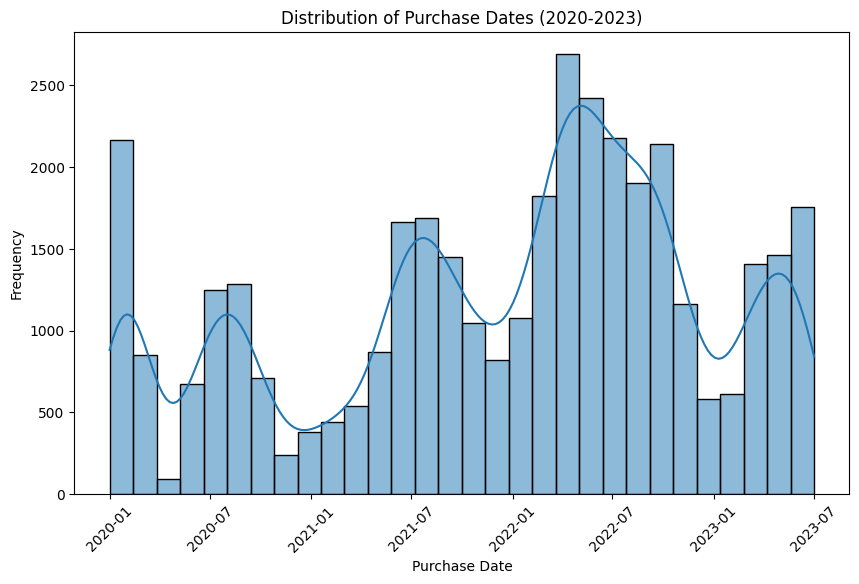

In [121]:
start_date = '2020-01-01'
end_date = '2023-12-31'
filtered_df = hb_dataset[(hb_dataset['PurchaseDate'] >= start_date) & (hb_dataset['PurchaseDate'] <= end_date)]

# Plot the distribution of purchase dates using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['PurchaseDate'], kde=True, bins=30)
plt.xlabel('Purchase Date')
plt.ylabel('Frequency')
plt.title('Distribution of Purchase Dates (2020-2023)')
plt.xticks(rotation=45)
plt.show()

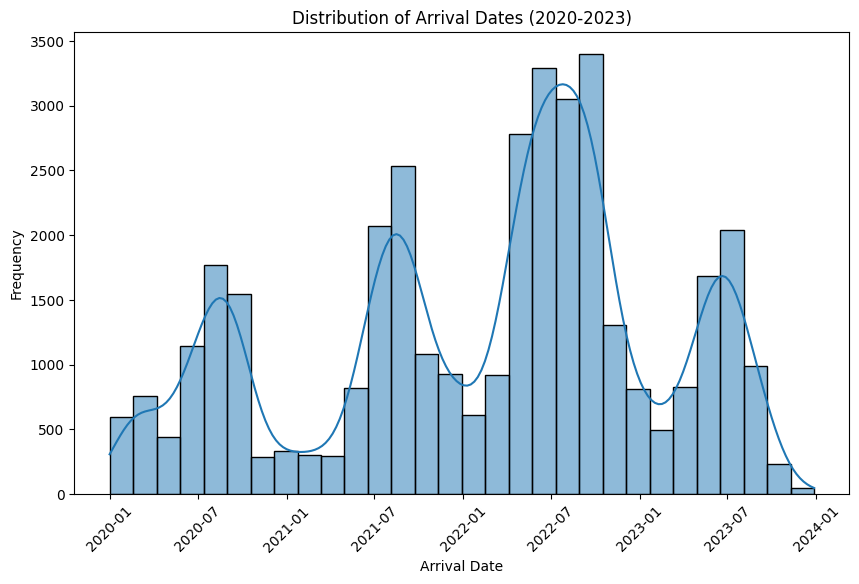

In [122]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['Arrival'], kde=True, bins=30)
plt.xlabel('Arrival Date')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Dates (2020-2023)')
plt.xticks(rotation=45)
plt.show()

Make sense. Most booking are at the beginning of the year and just before summer. Italians tends to go in vacation on August so in July the book.

  Distribution  KS Statistic  P-Value
0         norm      0.106293      0.0
1        expon      0.277902      0.0
2        gamma      0.113996      0.0
3      lognorm      0.106295      0.0
4         beta      0.137298      0.0


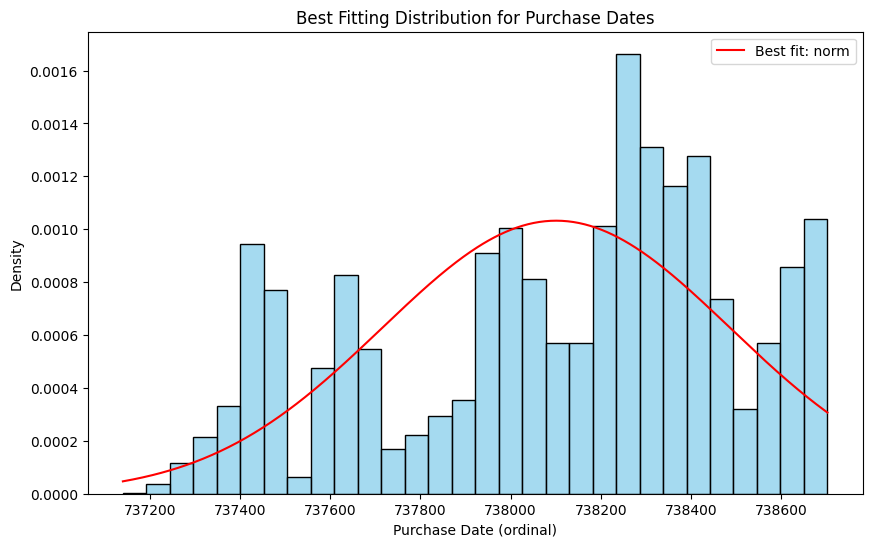

In [123]:

purchase_dates = hb_dataset['PurchaseDate'].apply(lambda x: x.toordinal())

distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(purchase_dates)
    ks_stat, p_value = stats.kstest(purchase_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(purchase_dates)

plt.figure(figsize=(10, 6))
sns.histplot(purchase_dates, kde=False, bins=30, color='skyblue', stat='density')

x = np.linspace(min(purchase_dates), max(purchase_dates), 500)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Purchase Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Purchase Dates')
plt.legend()
plt.show()


Some other studies have been found that a normal distribtion model quite well also arrival: https://www.sciencedirect.com/science/article/abs/pii/S0261517717302431


  Distribution  KS Statistic  P-Value
0         norm      0.118242      0.0
1        expon      0.253936      0.0
2        gamma      0.126179      0.0
3      lognorm      0.118242      0.0
4         beta      0.109427      0.0


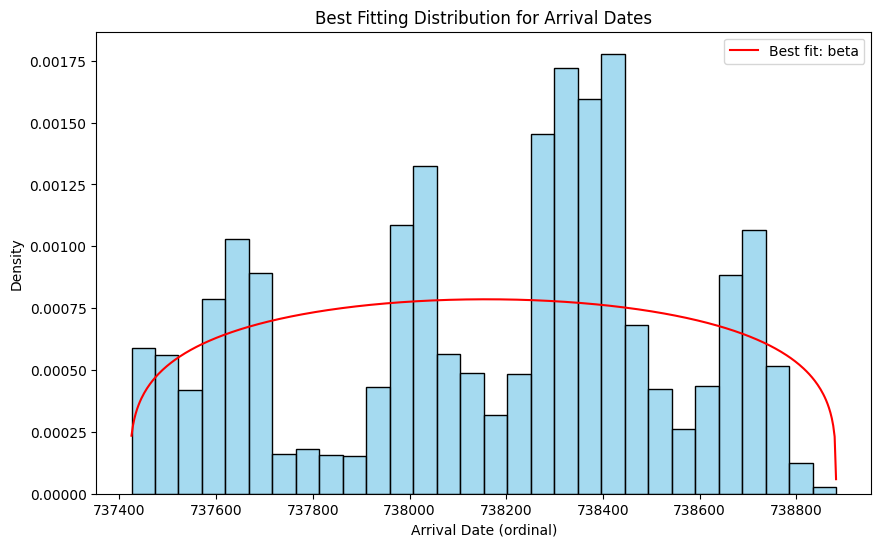

In [124]:
arrival_dates = hb_dataset['Arrival'].apply(lambda x: x.toordinal())

# List of distributions to check
distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

# Fit distributions and calculate KS statistic
results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(arrival_dates)
    ks_stat, p_value = stats.kstest(arrival_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

# Print results
results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

# Plot the best fitting distribution
best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(arrival_dates)

# Plot histogram and fitted distribution
plt.figure(figsize=(10, 6))
sns.histplot(arrival_dates, kde=False, bins=30, color='skyblue', stat='density')

# Plot the PDF of the best fitting distribution
x = np.linspace(min(arrival_dates), max(arrival_dates), 500)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Arrival Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Arrival Dates')
plt.legend()
plt.show()

## Which between our customers had most revenue?

In [125]:

revenue_per_hotel = hb_dataset.groupby(['HotelId', 'City'])['Total'].sum().reset_index()
revenue_per_hotel.sort_values(['Total'], inplace=True, ascending=False)
revenue_per_hotel.head()


,HotelId,City,Total
7,008,Olbia,6398486.80
5,006,Brindisi,2418291.75
3,004,Florence,1808414.24
6,007,Latina,1606252.54
4,005,Naples,1545058.55


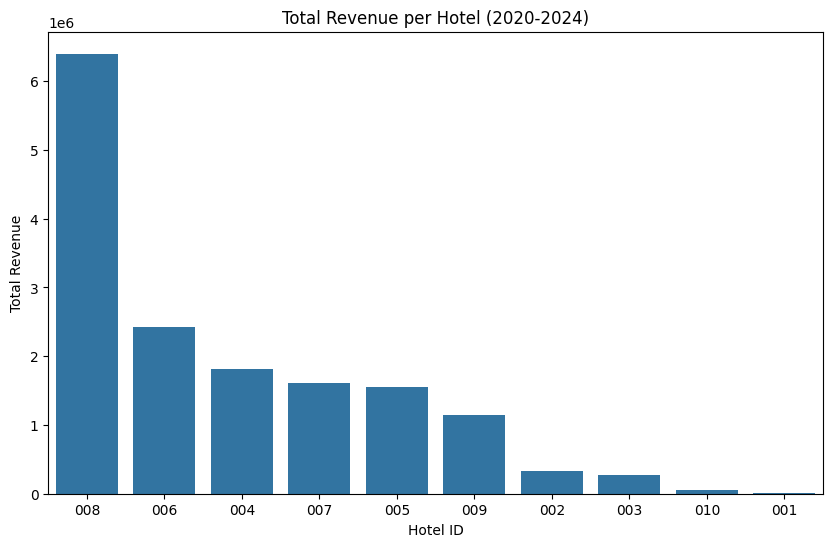

In [126]:
plt.figure(figsize=(10, 6))
sns.barplot(x='HotelId', y='Total', data=revenue_per_hotel)
plt.xlabel('Hotel ID')
plt.ylabel('Total Revenue')
plt.title('Total Revenue per Hotel (2020-2024)')
plt.show()

Now we want to see in the dataset the correlation between data, but for doing this and reaching the correlation matrix we need to reduce the 
features, distiguish between categorical and numerical and doing one shot encoding, removing redundant features. We will take, our best customer as sample to develop the metodology that can be applied to the others

In [127]:

# Identify numerical and categorical columns
numerical_cols = hb_dataset.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = hb_dataset.select_dtypes(include=['object']).columns
# Drop unnecessary columns
corr_df = hb_dataset.drop(columns=['Code', 'Arrival', 'Departure', 'PurchaseDate', 'LastModified'])
# One-hot encoding of categorical columns using pd.get_dummies
df_encoded = pd.get_dummies(corr_df, drop_first=True)
# Compute the correlation matrix
correlation_matrix = df_encoded.corr()
# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                     Status    Nights     Total  BookingDevice  \
Status             1.000000  0.645211  0.513571      -0.062003   
Nights             0.645211  1.000000  0.794623       0.030648   
Total              0.513571  0.794623  1.000000       0.047871   
BookingDevice     -0.062003  0.030648  0.047871       1.000000   
Arrival_Timestamp  0.178381  0.156894  0.198652       0.019119   
...                     ...       ...       ...            ...   
City_Olbia         0.053674 -0.019742  0.183897       0.118594   
City_Rome          0.012441  0.031340  0.039968       0.023393   
Season_Spring     -0.052579 -0.072694 -0.078285       0.020991   
Season_Summer      0.038156  0.090853  0.060638      -0.036531   
Season_Winter     -0.061001 -0.022598 -0.021612      -0.010555   

                   Arrival_Timestamp  Departure_Timestamp  Purchase_Timestamp  \
Status                      0.178381             0.177377            0.236060   
Nights                   

As expected some things are evident:
- Rome is the city with higher possible revenue having an high correlation with Price.
- Purchase Date and Arrival Date are correlated.
Less evident is the behaviour for Season and the cities:
- Expected behaviour that Olbia is overcrowded in Summer, since it is in Sardinia. 
For our purpose, compute demandscore is enough since we select just Arrival and treat the dataset like a time series.
Now we will focus in model selection based on Arrival since our goal is to compute the demand score per hotel.
There are two algorithms:
    - Prophet
    -  SARIMAX

We'll see which is the best one for this dataset and we compute the score but first we need to detect anomalies for time series. Before we need to see if data contains anomalies and treat them. We aggregate the data weekly.


In [128]:
hb_dataset.head()

,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
60820,2493115910/4283897556,1.0,Booking.com,2023-12-28,2024-01-04,7,4637.25,2023-06-04,NaN,2023-06-04 09:27:30,006,1703721600000000000,1704326400000000000,2023-06-04 09:27:30,1685836800000000000,Brindisi,Winter
60923,2745673363/4308678121,1.0,Booking.com,2023-12-27,2024-01-03,7,3892.05,2023-06-17,NaN,2023-06-17 18:09:53,006,1703635200000000000,1704240000000000000,2023-06-17 18:09:53,1686960000000000000,Brindisi,Winter
61034,3958853713/4337114239,1.0,Booking.com,2023-12-26,2024-01-02,7,2766.15,2023-07-02,NaN,2023-07-02 16:35:28,006,1703548800000000000,1704153600000000000,2023-07-02 16:35:28,1688256000000000000,Brindisi,Winter
60873,3854867487/4296773334,1.0,Booking.com,2023-12-26,2024-01-02,7,2620.35,2023-06-11,NaN,2023-06-11 10:53:57,006,1703548800000000000,1704153600000000000,2023-06-11 10:53:57,1686441600000000000,Brindisi,Winter
60750,2359160563/4271754038,1.0,Booking.com,2023-12-23,2023-12-31,8,2997.00,2023-05-28,NaN,2023-05-28 13:16:41,006,1703289600000000000,1703980800000000000,2023-05-28 13:16:41,1685232000000000000,Brindisi,Winter


## Anomalies exploration in the dataset.

In [129]:
# Aggregate the data to get weekly demand
hb_dataset['Week'] = hb_dataset['Arrival'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_demand = hb_dataset.groupby(['HotelId','Week']).size().reset_index(name='BookingCount')
weekly_demand.sort_values(by='Week')
weekly_demand.head()

,HotelId,Week,BookingCount
0,001,2020-05-18,2
1,001,2020-05-25,1
2,001,2020-06-08,3
3,001,2020-07-13,1
4,001,2020-07-20,8


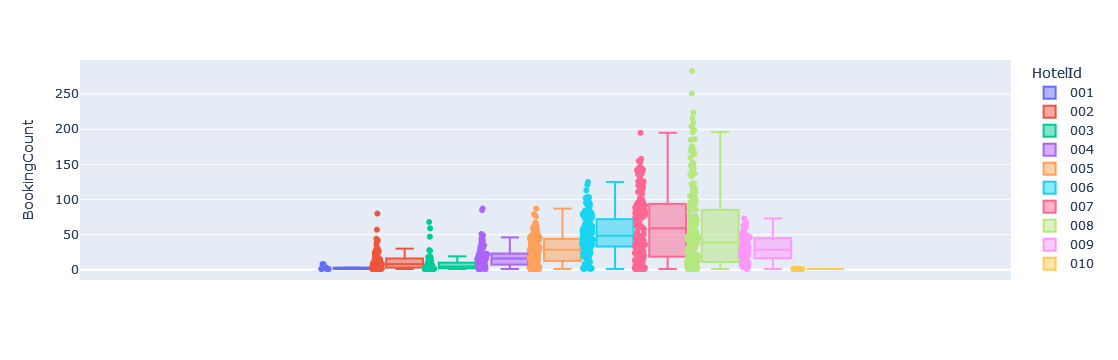

In [130]:

import plotly.express as px
fig = px.box(weekly_demand, y="BookingCount", color='HotelId', points='all')
fig.update_traces(quartilemethod="linear")
fig.show()


We use this diagram to assist with interpreting the boxplot:  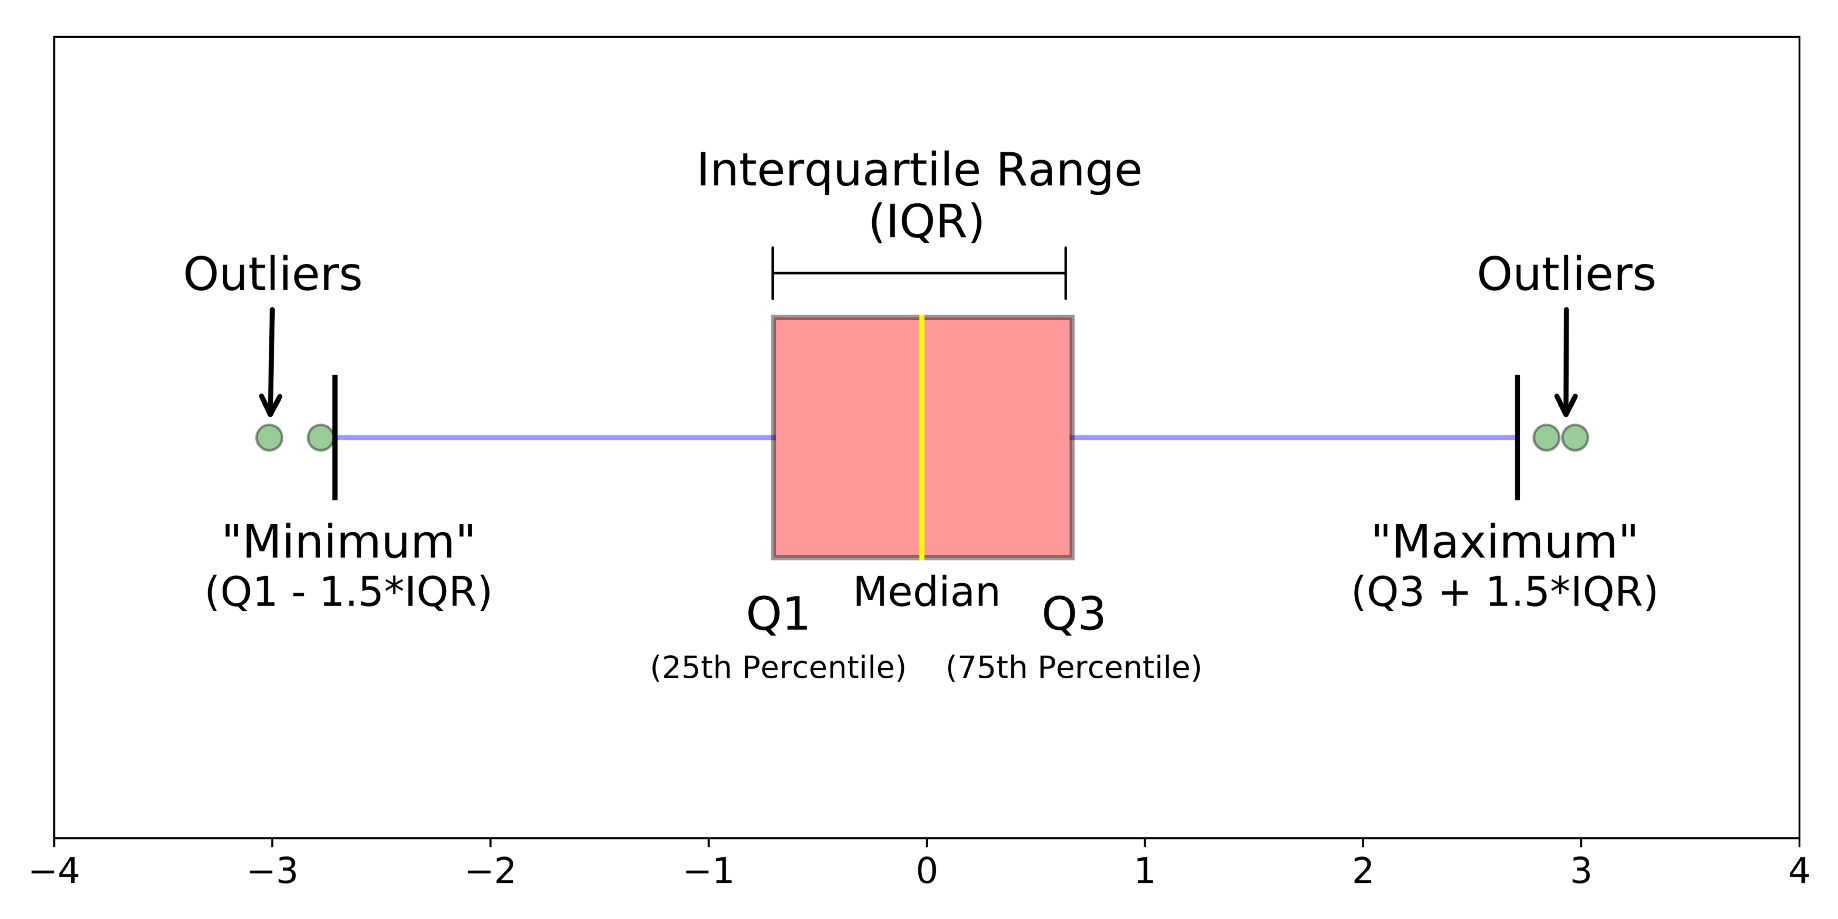 This comes from the bloog [Towards Data Science](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd5)
So using that model, there are hotel that have values that are candidate outliers in the time series distribution. Let's try to isolate the box plot and the booking per week per hotel.

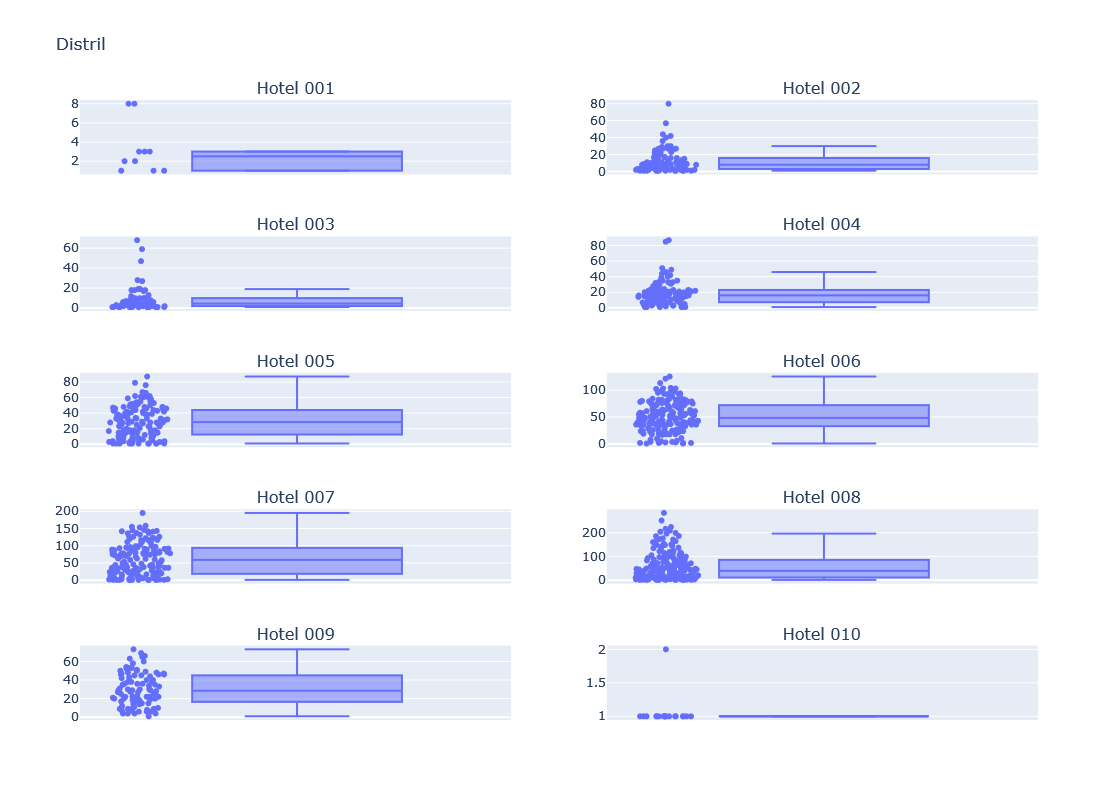

In [131]:

import plotly.express as px
from plotly.subplots import make_subplots

hotel_ids = weekly_demand['HotelId'].unique()
rows = (len(hotel_ids) + 1) // 2  # Calculate the number of rows needed
fig = make_subplots(rows=rows, cols=2, subplot_titles=[f'Hotel {hotel_id}' for hotel_id in hotel_ids])
for idx, hotel_id in enumerate(hotel_ids):
    hotel_data = weekly_demand[weekly_demand['HotelId'] == hotel_id]    
    box_plot = px.box(hotel_data, y="BookingCount", points='all')
    for trace in box_plot['data']:
        fig.add_trace(trace, row=(idx // 2) + 1, col=(idx % 2) + 1)
fig.update_layout(height=800, width=1000, showlegend=False, title_text="Distril")
fig.show()


The comprensive set of boxplot indicates that in each hotel there weeks that we've exceptional demand i.e. in Summer for each Hotel or it can be anomalies 
to be detected. We use an algorithm that comes a well known Italian university but at the moment let's understand seasonal decomposition. We pick up HotelId 008 because it is our most important customer in term or revenue and it is also the one that has more anomalies.

## Seasonal Decomposition
Seasonal decompositon will fundamental for our algorithm. In this [decomposition](https://math.unm.edu/~lil/Stat581/6-decomposition.pdf) a time series is split on three parts:
1. Trend: Long term pattern present in the series both increase or decrease.
2. Seasonal: Repeating cyclic pattern in the series where the cycle is specified in weeks, months, years.
3. Residual: Basically noise. It is the remaining part of the data after removing the trend and seasonal components.

We want to understand whether each time series is additive or multiplicative. To do this, we can use seasonal_decompose, which provides us with three separate components: trend, seasonality, and residual. If the seasonality component changes proportionally with the trend, we classify the time series as multiplicative. Otherwise, if the seasonality remains constant regardless of the trend, it is considered additive. Let me explai better: 

In our context, a hotel that experiences a fixed summer peak of 20 additional rooms fits an additive model. On the other hand, a hotel that sees a 20% increase in bookings every summer would better fit a multiplicative time series. In the case of Hotel08 is an additive model since it in multiplicative decomposition despite the the trend, the seasonal component has the same peaks  and in additive model except some noise it is pretty constant.
                                      - 

In [132]:
import plotly.graph_objs as go
import statsmodels.api as sm
hotel_data = weekly_demand[weekly_demand['HotelId'] == '008']    


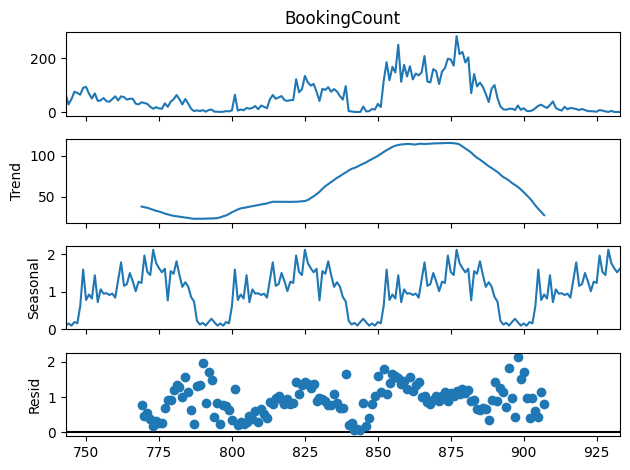

In [133]:
res = sm.tsa.seasonal_decompose(hotel_data['BookingCount'].interpolate(),
                                period=52,
                                model='multiplicative')
resplot = res.plot()

Here we can see the trend that tend to decline for this hotel due to the seasonal effect.

In [134]:
res.resid[np.isfinite(res.resid) == False] = 0

In [135]:
res_resid = sm.tsa.seasonal_decompose(res.resid.interpolate(),
                                period=52,
                                model='additive')

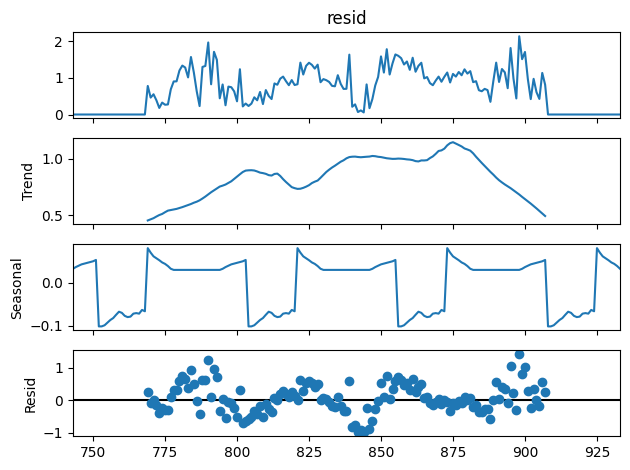

In [136]:
resplot = res_resid.plot()

## Anomaly detection.
An anomaly in a time series refers to a data point or sequence of data points that significantly deviates from the expected patterns or trends typically observed in the data. These anomalies can manifest in various ways, such as abrupt changes in values, an increase in NULL values, missing data segments, or other irregular patterns that deviate from normal fluctuations. As discussed in [Anomaly Detection in Time Series: A Comprehensive Evaluation](https://www.vldb.org/pvldb/vol15/p1779-wenig.pdf), such anomalies can indicate significant events or issues within the system being analyzed. In our specific context, an anomaly might suggest that during certain periods, the demand exceeded the hotel's operational capacity.
Numerous techniques for anomaly detection have been evaluated in the literature. During our research, we identified an effective algorithm that can be applied to the residual component of a seasonal-trend decomposition, utilizing the Isolation Forest method. This approach is both efficient and fast. We propose this algorithm for anomaly detection at each hotel level, as inspired by the work on [Unsupervised Anomaly Detection on Server Metrics](https://webthesis.biblio.polito.it/21240/1/tesi.pdf).

#### Anomaly detection with Isolation Forest
The steps of the algorithm are:
1. Normalization of the time series
2. Seasonal trend decomposition of the time series to extract the residual.
3. Applying ISOLATION FOREST to the residual
4. Remove points not considered anomalous by the Isolation Forest
5. Apply DBSCAN to the points outside the confidence region to obtain clusters of points close to each other
6. Points that do not belong to any cluster are the anomalies

[Isolation Forest](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8888179) algorithm directly seeks anomalous points based on the contamination parameter. First, the algorithm builds a forest of random decision trees. After training, it assigns an anomaly score to each data point. At this stage, we don't know whether a point is an inlier or outlier. The contamination parameter serves as a threshold, determining how many points are classified as outliers by converting these raw scores into inlier or outlier labels.

In [137]:
!pip install matplot statsmodels numpy

### 1. Normalization of time series
We will now proceed with analyzing the time series data from Hotel 008, as this dataset appears interesting. Specifically, the boxplot has revealed some outlier points exceeding the maximum threshold. At the conclusion of this analysis, we will write a function that can be applied to each hotel.

In [138]:
from sklearn.preprocessing import MinMaxScaler
# random forest requirement
# normalization scales each value of booking count to range 0.1
min_max_scaler = MinMaxScaler(feature_range=(0,1))
booking_count = hotel_data[['BookingCount']] 
booking_count_scaled = min_max_scaler.fit_transform(booking_count)
hotel_data['BookingCount_Scaled'] = booking_count_scaled
booking_hotel_scaled = hotel_data.drop(columns=['HotelId'])

### 2. Seasonal-Trend decomposition using LOESS

In [139]:
booking_hotel_scaled.head()

,Week,BookingCount,BookingCount_Scaled
743,2019-12-30,67,0.234043
744,2020-01-06,29,0.099291
745,2020-01-13,49,0.170213
746,2020-01-20,76,0.265957
747,2020-01-27,72,0.251773


<Axes: >

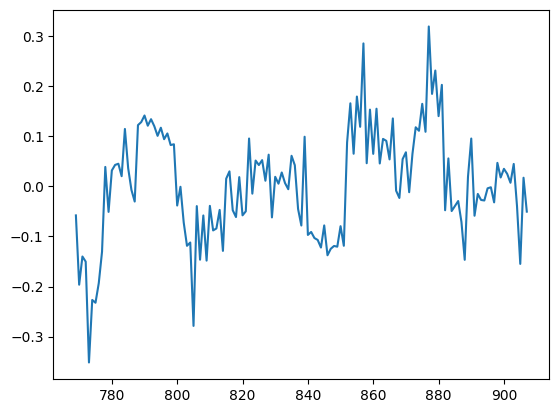

In [140]:
season_decomposed = sm.tsa.seasonal_decompose(booking_hotel_scaled['BookingCount_Scaled'].interpolate(),period=52)
residual = season_decomposed.resid
residual.plot()

### 3. Apply Isolation Forest on Residual


In [141]:
residual.head()

743   NaN
744   NaN
745   NaN
746   NaN
747   NaN
Name: resid, dtype: float64

In [142]:
data = residual.fillna(residual.mean())
data.count()

191

In [143]:
data.head()

743    0.003253
744    0.003253
745    0.003253
746    0.003253
747    0.003253
Name: resid, dtype: float64

In [144]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest()  
values = clf.fit_predict(data.values.reshape(-1, 1))
booking_hotel_scaled['anomaly_score'] = values
booking_hotel_scaled['is_anomaly'] = booking_hotel_scaled['anomaly_score'] == -1

In [145]:
booking_hotel_scaled.head(50)

,Week,BookingCount,BookingCount_Scaled,anomaly_score,is_anomaly
743,2019-12-30,67,0.234043,1,False
744,2020-01-06,29,0.099291,1,False
745,2020-01-13,49,0.170213,1,False
746,2020-01-20,76,0.265957,1,False
747,2020-01-27,72,0.251773,1,False
748,2020-02-03,65,0.226950,1,False
749,2020-02-10,91,0.319149,1,False
750,2020-02-17,94,0.329787,1,False
751,2020-02-24,69,0.241135,1,False
752,2020-03-02,51,0.177305,1,False


### 4. Remove the points that are not consided anomalies by IsolationForest.

In [146]:
hotel_anomalies = booking_hotel_scaled[booking_hotel_scaled['anomaly_score']==-1]
hotel_anomalies.head(46)

,Week,BookingCount,BookingCount_Scaled,anomaly_score,is_anomaly
770,2020-07-06,34,0.117021,-1,True
771,2020-07-13,31,0.106383,-1,True
772,2020-07-20,20,0.067376,-1,True
773,2020-07-27,13,0.042553,-1,True
774,2020-08-03,19,0.063830,-1,True
775,2020-08-10,14,0.046099,-1,True
776,2020-08-17,13,0.042553,-1,True
789,2020-11-16,4,0.010638,-1,True
790,2020-11-30,8,0.024823,-1,True
804,2021-04-26,7,0.021277,-1,True


In [147]:
print(f'Anomalies count {hotel_anomalies.shape[0]} over {booking_hotel_scaled.shape[0]}')

Anomalies count 26 over 191


### 5.Apply DBScan on the Isolation Forest Anomalies. 
The points that don't belong to any cluster are anomalies and we can pass from 46 to much less. The eps is placed to 0.1. [DBScan](https://dl.acm.org/doi/10.1145/3068335) has num points and eps as hyperparameter. A better way to select the value of eps is described in [Fast Density-Based Clustering with R](https://www.jstatsoft.org/article/view/v091i01). The paper proposes using KNN to estimate the distance from each point to its nearest neighbor within the same partition, followed by sorting and selecting the minimum. However, we opted to use an empirical value derived from direct data exploration.

In [148]:
hotel_anomalies['Week_float'] = hotel_anomalies['Week'].apply(lambda x: x.timestamp())
hotel_anomalies.head()

,Week,BookingCount,BookingCount_Scaled,anomaly_score,is_anomaly,Week_float
770,2020-07-06,34,0.117021,-1,True,1.593994e+09
771,2020-07-13,31,0.106383,-1,True,1.594598e+09
772,2020-07-20,20,0.067376,-1,True,1.595203e+09
773,2020-07-27,13,0.042553,-1,True,1.595808e+09
774,2020-08-03,19,0.063830,-1,True,1.596413e+09


In [149]:
from sklearn.cluster import DBSCAN
X = hotel_anomalies[['BookingCount_Scaled']].values
dbscan = DBSCAN(eps=0.1, min_samples=10)
dbscan.fit(X)
hotel_anomalies['Cluster'] = dbscan.labels_
outliers = hotel_anomalies[hotel_anomalies['Cluster'] == -1]
outliers.count()

Week                   11
BookingCount           11
BookingCount_Scaled    11
anomaly_score          11
is_anomaly             11
Week_float             11
Cluster                11
dtype: int64

In [150]:
outliers.head()

,Week,BookingCount,BookingCount_Scaled,anomaly_score,is_anomaly,Week_float,Cluster
853,2022-04-11,186,0.656028,-1,True,1.649635e+09,-1
855,2022-04-25,169,0.595745,-1,True,1.650845e+09,-1
857,2022-05-09,251,0.886525,-1,True,1.652054e+09,-1
859,2022-05-23,176,0.620567,-1,True,1.653264e+09,-1
861,2022-06-06,171,0.602837,-1,True,1.654474e+09,-1


In Italy August, December and beginning of January are typically vacation time so it is normal having anomalies.

In [151]:
from datetime import datetime
collect_idx_to_remove = []
for idx,value in outliers.iterrows():
    date = value[0].to_pydatetime()
    # we exclude december, august, and january till 6
    if ((date.month == 12) or (date.month == 8) or (date.month ==1 and date.day < 7)):
        collect_idx_to_remove.append(idx)
outliers_cleaned = outliers.drop(index=collect_idx_to_remove)
outliers_cleaned.head()

,Week,BookingCount,BookingCount_Scaled,anomaly_score,is_anomaly,Week_float,Cluster
853,2022-04-11,186,0.656028,-1,True,1.649635e+09,-1
855,2022-04-25,169,0.595745,-1,True,1.650845e+09,-1
857,2022-05-09,251,0.886525,-1,True,1.652054e+09,-1
859,2022-05-23,176,0.620567,-1,True,1.653264e+09,-1
861,2022-06-06,171,0.602837,-1,True,1.654474e+09,-1


Now we can act in two ways in case of forecasting:
- remove the outliers in case of error since
- evalutating when happens and if they are legit (high season, events, christmas) keep them.

We can remove safely the outliners except for the week of Christmas and First week of the year We can establish, having seen the data distribution that **peak are not anomalies** in:
1. Christmas period
2. First week of the year
3. August

Now we need to generalize for each hotel. We're gonna define a function **clean_time_series** in Python that include all the code we've see to clean up from outliers and a **restrict_outliers** that take in account the vacation times.

In [152]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from datetime import datetime
def restrict_outliers(outliers: pd.DataFrame) -> pd.DataFrame:
    collect_idx_to_remove = []
    for idx,value in outliers.iterrows():
        date = value[1].to_pydatetime()
        # we exclude december, august, and january till 6
        if ((date.month == 12) or (date.month == 8) or (date.month ==1 and date.day < 7)):
            collect_idx_to_remove.append(idx)
    outliers.drop(index=collect_idx_to_remove)
    return outliers

# we can apply this function to each hotel to clean data
def clean_time_series(hd: pd.DataFrame) -> pd.DataFrame:
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    booking_count = hd[['BookingCount']] 
    booking_count_scaled = min_max_scaler.fit_transform(booking_count)
    hd['BookingCount_Scaled'] = booking_count_scaled
    season_decomposed = sm.tsa.seasonal_decompose(hd['BookingCount_Scaled'].interpolate(),period=52)
    residual = season_decomposed.resid
    data = residual.fillna(residual.mean())
    clf = IsolationForest()  
    values = clf.fit_predict(data.values.reshape(-1, 1))
    hd['anomaly_score'] = values
    hotel_anomalies = hd[hd['anomaly_score']==-1]
    X = hotel_anomalies[['BookingCount_Scaled']].values
    dbscan = DBSCAN(eps=0.1, min_samples=5)
    dbscan.fit(X)
    hotel_anomalies['Cluster'] = dbscan.labels_
    outliers = restrict_outliers(hotel_anomalies[hotel_anomalies['Cluster'] == -1])
    hd = hd.drop(outliers.index.to_list())
    return hd


## Model Selection for Demand Score
Now we clean our scaled data to validate which model is better and then we start with model selection. We have to investigate between Facebook [Prophet](https://peerj.com/preprints/3190.pdf) and SARIMAX.


In [153]:
hotel_evaluation_ds = clean_time_series(hotel_data)

In [154]:
print(f'Series size after cleaning {hotel_evaluation_ds.shape[0]} and before {hotel_data.shape[0]}')

Series size after cleaning 190 and before 191


In [155]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")


demand_ds = hotel_evaluation_ds[['Week','BookingCount']]
demand_ds.head()

,Week,BookingCount
743,2019-12-30,67
744,2020-01-06,29
745,2020-01-13,49
746,2020-01-20,76
747,2020-01-27,72


### Descriptive Analytics on cleaned dataset
A lot of transformation has been effected the original data. So before passing to see Prophet and crafting model a bit of descriptive analytics is needed 
on the resulting model. So we'd like to see:
- The behaviour in the first 12 months: trend and standard deviation
- ACF plots and PACF plots (https://itsudit.medium.com/deciphering-acf-and-pacf-plots-a-guide-to-time-series-forecasting-3323948935fb) that are useful to intepret a time series.

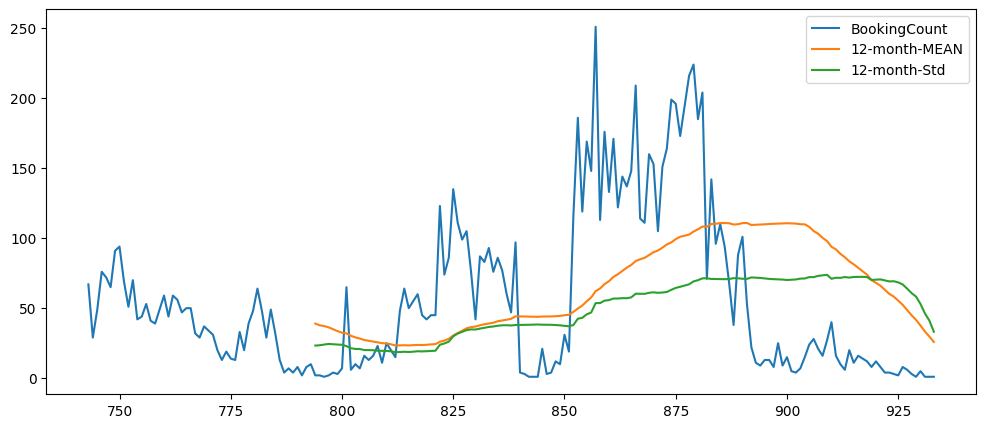

In [156]:
df = demand_ds.copy()
df['12-month-MEAN'] = df['BookingCount'].rolling(window=52).mean()
df['12-month-Std'] = df['BookingCount'].rolling(window=52).std()
df[['BookingCount','12-month-MEAN','12-month-Std']].plot(figsize=(12,5));


TypeError: float() argument must be a string or a real number, not 'Timestamp'

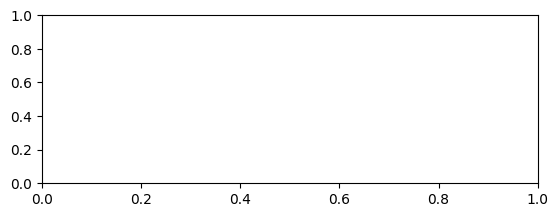

In [157]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(211)
plot_acf(demand_ds, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(demand_ds, ax=pyplot.gca())
pyplot.show()


Both plot show us a negative trend in the correlation between variables for this time series. The series decays after some lags to -0.24 as bottom whereas exihibit a strong correlation initally. We pass now at the 

[Prophet](https://facebook.github.io/prophet/) imposes the strict condition that the input columns must be named as ds (the time column) and y (the metric column). So, we must rename the columns in our dataframe.


In [ ]:
prophet_ds = demand_ds.rename(columns={'Week': 'ds',
                        'BookingCount': 'y'})
prophet_ds.head()



In [ ]:
ax = prophet_ds.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Weekly Room Booking for Hotel 008')
ax.set_xlabel('Date')
plt.show()

In [ ]:
prophet_model = Prophet(interval_width=0.90)

In [ ]:
model = prophet_model.fit(prophet_ds)

Now we tell to Prophet to generate future dataset. The next year: 2025. Later we use the same method to aggregate data to compute demand score. The make_future_dataframe starts from the beginning of the dataset so we have to specify the exact number of weeks in period.

In [ ]:
prophet_future_ds = model.make_future_dataframe(periods=60, freq='W')
#prophet_future_ds = prophet_future_ds[(prophet_future_ds['ds'] >= '2025-01-01') & (prophet_future_ds['ds'] <= '2025-12-31')] 
prophet_future_ds.tail()

In [ ]:
prophet_demand_score_forecast = model.predict(prophet_future_ds)
prophet_demand_score_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

In [ ]:
model.plot(prophet_demand_score_forecast, uncertainty=True)

In [ ]:
prophet_model.plot_components(prophet_demand_score_forecast)



In [ ]:
# prophet has cross validaton
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(prophet_model, initial='365 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)
df_p.head()

In [ ]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [ ]:
!pip install optuna

# Prophet Hyperparameter Tuning
Accordingly to prophet documentation, if we want to tune parameters, the first ones to be tunned should be:
1. **changepoint_prior_scale**: This is probably the most impactful parameter. It determines the flexibility of the trend and, in particular, how much the trend changes at the trend changepoints.
2. **seasonality_prior_scale**: This parameter controls the flexibility of the seasonality.
3. **holidays**: This controls flexibility to fit holiday effects.
4. **seasonality_mode**: Options are ['additive', 'multiplicative'].

We will use [Optuna](https://optuna.org/) for hyperparamter tuning. The main reason are the speed of execution and flexibility: it adapts to any machine learning model, it is written in Rust with python binding (so it is fast) and uses a different approach from GridSearch. Instead of exploring randomly the parameter space and trying to find the best uses an heuristic to prune the solutions and converge faster. It works in several step:
- define an objective function
- create a number of trials
- create study that trigger the trials
- find the best parameters as result ot that study.

First from [Prophet Hyperparamter documentation](https://facebook.github.io/prophet/docs/diagnostics.html) we see which are parameter interested to us.

In [ ]:
import optuna


In [ ]:
ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2020-01-01', '2021-01-01','2022-01-01','2023-01-01'])})  
befana = pd.DataFrame({'holiday': 'Befana', 'ds' : pd.to_datetime(['2020-01-06', '2021-01-06','2022-01-06','2023-01-06'])})
# Day in which italy has been freed by the nazis! Hasta la victoria siempre!
resistence_day = pd.DataFrame({'holiday': 'Resistence Day', 'ds' : pd.to_datetime(['2020-04-25', '2021-04-25','2022-04-25','2023-04-25'])})
lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2020-05-01', '2021-05-01', '2022-05-01','2023-05-01'])})
republic_day = pd.DataFrame({'holiday': 'Republic Day', 'ds' : pd.to_datetime(['2020-06-02', '2021-06-02', '2022-06-02','2023-06-02'])})
midsummer = pd.DataFrame({'holiday': "Midsummer Day", 'ds' : pd.to_datetime(['2020-08-15', '2021-08-15', '2022-08-15','2023-08-15'])})
maryday = pd.DataFrame({'holiday': 'St.Nicholas', 'ds' : pd.to_datetime(['2020-12-08', '2021-12-08','2022-12-09','2023-12-08'])})
christmas = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2020-12-25', '2021-12-25','2022-12-25','2023-12-25'])})
ststevenday=pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2020-12-26', '2021-12-26','2022-12-26','2023-12-26'])})
italian_public_holidays = pd.concat([ny, befana, resistence_day, lab, republic_day, midsummer, maryday, christmas,ststevenday])
italian_public_holidays.head()

Now we have to define the objective function using above parameters variation.

In [ ]:
def objective(trial):
    params = {
        'holidays': italian_public_holidays,  # Ensure this is a DataFrame with 'ds' and 'holiday' columns
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.2, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
    }
    
    m = Prophet(**params)
    m.add_seasonality(name='weekly', period=7, fourier_order=trial.suggest_int('weekly_seasonality', 5, 10))
    m.add_seasonality(name='yearly', period=365.25, fourier_order=trial.suggest_int('yearly_seasonality', 1, 20))
    
    m.fit(prophet_ds)

    number_initial_days = (prophet_ds['ds'].max() - prophet_ds['ds'].min()).days - 28
    if number_initial_days < 0:
        raise ValueError("Insufficient data for cross-validation")
    
    df_cv = cross_validation(m, 
                             initial=f'{number_initial_days} days', 
                             period='7 days', 
                             horizon='7 days',
                             parallel="processes")

    df_p = performance_metrics(df_cv, rolling_window=1)
    if df_p.empty:
        raise ValueError("Cross-validation returned an empty performance metrics dataframe")

    return df_p['rmse'].values[0]


In [ ]:
study = optuna.create_study(study_name="demandscore_prophet",direction='minimize')
# in production we can try up to 100 but in this case we limit to 10
study.optimize(objective, n_trials=10)

In [ ]:
study.best_params

In [ ]:
prophet_model = Prophet(**study.best_params)
prophet_model.fit(prophet_ds)
number_initial_days = (prophet_ds['ds'].max() - prophet_ds['ds'].min()).days - 28
df_cv = cross_validation(prophet_model, initial=f'{number_initial_days} days', period='7 days', horizon='7 days',parallel="processes")
df_p = performance_metrics(df_cv, rolling_window=1)
df_p.head()

In [ ]:
future_ds = model.make_future_dataframe(periods=60, freq='W')
forecast = prophet_model.predict(future_ds)
model.plot(forecast, uncertainty=True)

In [ ]:
future_ds.tail()

In [ ]:
prophet_model.plot_components(forecast)

In [ ]:
prophet_ds['y'].describe()

The mean of booked room in the dataset is 54, here the rmse is 1.7, it means in the temporal window of 20 days the model can at least have an errors of 2 booking,that it is pretty fine for the problem.

### SARIMAX per Demand Score

The ACF plot has lags on the horizontal axis and correlations on the vertical axis. The first value y0 is always 1.
The slow decrease in the ACF as the lags increase is due to the trend, no effect due to the seasonality. This means that forecasting in the long period will be less accurate or invalid.

In [ ]:
count = int(demand_ds.count()[0])
count_test = int(round((20 / demand_ds.count()) * 100)[0])
print(f"Test items {count_test}")

In [ ]:
train_data= df.iloc[:len(demand_ds)-12]
test_data= df.iloc[len(demand_ds)-12:]

In [ ]:
test_data=demand_ds[count-count_test:]
test_data.count()

In [ ]:
arima_model = SARIMAX(train_data['BookingCount'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
arima_model_fit = arima_model.fit(disp=False)
arima_model_fit.summary()


In [ ]:
arima_model_fit.plot_diagnostics(figsize=(16,10))

In [ ]:
start= len(train_data)
end= len(train_data) + len(test_data) -1
pred= arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")
pred.head()


In [ ]:
#Plot the predictions on Test
title= "Actual v/s Predictions for Test dataset"
test_data["BookingCount"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)          


In [ ]:
#Evaluate the model
from sklearn.metrics import root_mean_squared_error as rmse
mse= mean_squared_error(test_data["BookingCount"],pred)
rmse_sarima= rmse(test_data["BookingCount"], pred)

print(f"Root Mean Square is {rmse_sarima}")
print(f"Mean Square Error is {mse}")

RMSE is very high and unaccettable. Let see if we can do something with optuna hyper parameter tuning

In [ ]:

#Generate all different combinations of p, d and q triplets
#Generate all different combinations of p, d, q and s triplets
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
def objective_sarima(trial):
    order = trial.suggest_categorical('order', pdq)
    seasonal_order = trial.suggest_categorical('seasonal_order', pdqs)
    trend = trial.suggest_categorical('trend', ['n', 'c', 't', 'ct', None])
    start= len(train_data)
    end= len(train_data) + len(test_data) -1
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, trend=trend, initialization='approximate_diffuse')    
    mdl = model.fit(disp=False)
    start= len(train_data)
    end= len(train_data) + len(test_data) -1
    predictions= mdl.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")
    rmse_sarima= rmse(test_data["BookingCount"], predictions)
    return rmse_sarima
study=optuna.create_study(direction="minimize")
study.optimize(objective_sarima,n_trials=10)



## Model comparison.
Better Prophet with hyperpameter tuning, reason:
- Easier to user and optimize with optuna.
- Mean Average Error (MSE): Tells us the average magnitude of the forecast errors. 
- Mean Square Error: Emphasizes larger errors more than MAE. 
- Root Mean Square Error: Provides an error measure in the same units as the demand. 

We choose Prophet beacuse is easy to use and tune with optuna, obtaining better RMSE. The Demand Score will be computed using the test set and doing the percentuage of average booking.


## Computing DemandScore

In [ ]:
print(forecast)

In [ ]:
demand_score_hotel_08 =  (forecast['y'].mean() / int(forecast.count())) * 100
print(f"Demand Score per hotelId 008: {demand_score_hotel_08}")

# <b>Review Score</b> using BERT Sentiment Analysis over Tripadvisor Reviews.

<p>Hotel performance in terms of revenue depends stricly from online reputation (cit), so our goal in designing <b>HotelRank</p> algorithm is to analyze reviews about our customers hotel and provide an unique score to put a linear factor in HotelRank. We can name that score as <i>review score</i>.</p>
<p><B>ReviewScore = Hotel_Rating - (0.5 * #number_negative review) + (0.25 * number of positive review)</B></p>
<p>Here we emphasize the idea that is better not having negitive than positive reviews. To compute this formula we need we are in need to perform sentiment analysis over hotel reviews.</p><p>In case the <b>ReviewScore</b> is negative we assume that his weight to HotelRank is 0</p>


The state-of-the-art sentiment analysis can be accomplished by fine-tuning pretrained BERT models with sentiment-analysis datasets. Fine-tuning is accomplished by further training a pretrained model for a limited number of epochs and with a reduced learning rate. We have collected the review using a scraper that we've coded in Go programming Language.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(samples):
    return tokenizer(samples['Text'], truncation=True)

tokenized_imdb = imdb.map(tokenize, batched=True)

Now that the reviews are tokenized, they need to be converted from [Hugging Face datasets](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset) into [TensorFlow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) with Hugging Face’s [Dataset.to_tf_dataset](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.to_tf_dataset) method. The collating function passed to that method dynamically pads the sequences so they’re all the same length. You can also ask the tokenizer to do the padding, but padding performed that way is static and requires more memory:
                                                                                           

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

train_data = tokenized_imdb['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)

validation_data = tokenized_imdb['test'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator
)

Now you’re ready to fine-tune. Call `fit` on the model as usual, but set the `Adam` optimizer’s learning rate (the nominal amount that weights and biases are adjusted during backpropagation passes) to 0.00002, which is a fraction of the default learning rate of 0.001:

In [ ]:
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.compile(Adam(learning_rate=2e-5), metrics=['accuracy'])
hist = model.fit(train_data, validation_data=validation_data, epochs=3)

Plot the training and accuracy.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Finish up by defining an `analyze_text` function that returns a sentiment score and using it to score a positive review for sentiment. The model returns an object wrapping a tensor containing unnormalized sentiment scores (negative and positive), but you can use TensorFlow’s `softmax` function to normalize them to values from 0.0 to 1.0:

In [ ]:
import glob
import panda as pd
import tensorflow as tf

def analyze_text(text, tokenizer, model):
    tokenized_text = tokenizer(text, padding=True, truncation=True, return_tensors='tf')
    prediction = model(tokenized_text)
    return tf.nn.softmax(prediction[0]).numpy()[0][1]

review_data = glob.glob('review_data/*.csv')
datasets = [pd.read_csv(filedata) for filedata in review_data]
datasets[0].head()

# Cancellation Score: Analysis on Cancellations

In our context the cancellation score will based on the number of cancellatation, so we can consider the booking cancelled or not cancelled. 
Blastnedd PSM. We need to aggregate the three categories on the clean dataset in two, understand the feature, do feature reduction thru PCA if it is needed.

In [158]:
hb_dataset.head()

,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season,Week
60820,2493115910/4283897556,1.0,Booking.com,2023-12-28,2024-01-04,7,4637.25,2023-06-04,NaN,2023-06-04 09:27:30,006,1703721600000000000,1704326400000000000,2023-06-04 09:27:30,1685836800000000000,Brindisi,Winter,2023-12-25
60923,2745673363/4308678121,1.0,Booking.com,2023-12-27,2024-01-03,7,3892.05,2023-06-17,NaN,2023-06-17 18:09:53,006,1703635200000000000,1704240000000000000,2023-06-17 18:09:53,1686960000000000000,Brindisi,Winter,2023-12-25
61034,3958853713/4337114239,1.0,Booking.com,2023-12-26,2024-01-02,7,2766.15,2023-07-02,NaN,2023-07-02 16:35:28,006,1703548800000000000,1704153600000000000,2023-07-02 16:35:28,1688256000000000000,Brindisi,Winter,2023-12-25
60873,3854867487/4296773334,1.0,Booking.com,2023-12-26,2024-01-02,7,2620.35,2023-06-11,NaN,2023-06-11 10:53:57,006,1703548800000000000,1704153600000000000,2023-06-11 10:53:57,1686441600000000000,Brindisi,Winter,2023-12-25
60750,2359160563/4271754038,1.0,Booking.com,2023-12-23,2023-12-31,8,2997.00,2023-05-28,NaN,2023-05-28 13:16:41,006,1703289600000000000,1703980800000000000,2023-05-28 13:16:41,1685232000000000000,Brindisi,Winter,2023-12-18


In [159]:
hb_dataset.columns

Index(['Code', 'Status', 'BookingChannel', 'Arrival', 'Departure', 'Nights',
       'Total', 'PurchaseDate', 'BookingDevice', 'LastModified', 'HotelId',
       'Arrival_Timestamp', 'Departure_Timestamp', 'LastModified_Timestamp',
       'Purchase_Timestamp', 'City', 'Season', 'Week'],
      dtype='object')

In [ ]:
len(hb_dataset.columns)

We've noticed oo many feature and some of them are dependent, our objective is to understand when a reservation is confirmed or cancelled. Let's try to reduce them thru PCA. We want to drop all dates and keep the timestamp since are numerical and spread informations. Let's identify again which are the numerical and which are the categorical before doing the PCA.

In [171]:
hb_dataset.describe()

,Status,Nights,Total,BookingDevice,Arrival_Timestamp,Departure_Timestamp,Purchase_Timestamp
count,39340.000000,39340.000000,39340.000000,6280.000000,3.934000e+04,3.934000e+04,3.934000e+04
mean,0.589553,1.516548,396.177232,1.513376,1.642224e+18,1.642482e+18,1.636262e+18
std,0.525452,1.967660,667.932308,0.847213,3.238879e+16,3.238956e+16,3.338754e+16
min,0.000000,0.000000,0.000000,0.000000,1.577837e+18,1.577923e+18,1.553213e+18
25%,0.000000,0.000000,0.000000,1.000000,1.622678e+18,1.622938e+18,1.612742e+18
50%,1.000000,1.000000,144.900000,2.000000,1.651190e+18,1.651363e+18,1.645142e+18
75%,1.000000,2.000000,531.000000,2.000000,1.664064e+18,1.664323e+18,1.661234e+18
max,2.000000,30.000000,20124.000000,2.000000,1.703722e+18,1.704326e+18,1.688256e+18


In [172]:
hb_dataset.dtypes

Code                              object
Status                           float64
BookingChannel                    object
Arrival                   datetime64[ns]
Departure                 datetime64[ns]
Nights                             int64
Total                            float64
PurchaseDate              datetime64[ns]
BookingDevice                    float64
LastModified              datetime64[ns]
HotelId                           object
Arrival_Timestamp                  int64
Departure_Timestamp                int64
LastModified_Timestamp    datetime64[ns]
Purchase_Timestamp                 int64
City                              object
Season                            object
Week                      datetime64[ns]
dtype: object

In [184]:
canc_score_ds = hb_dataset[["Status","BookingChannel","Nights","Total","HotelId","Arrival_Timestamp","Departure_Timestamp","Purchase_Timestamp","City","Season"]]
canc_score_ds.sort_values(by=['Purchase_Timestamp','Arrival_Timestamp','Departure_Timestamp'])

,Status,BookingChannel,Nights,Total,HotelId,Arrival_Timestamp,Departure_Timestamp,Purchase_Timestamp,City,Season
130157,1.0,Sito,4,2458.40,008,1582156800000000000,1582502400000000000,1553212800000000000,Olbia,Winter
13103,0.0,Synxis,0,0.00,003,1598227200000000000,1598486400000000000,1555977600000000000,Florence,Summer
13102,0.0,Synxis,0,0.00,003,1598227200000000000,1598486400000000000,1555977600000000000,Florence,Summer
13100,0.0,Synxis,0,0.00,003,1631664000000000000,1631923200000000000,1555977600000000000,Florence,Fall
50996,1.0,Expedia,4,1046.25,006,1579132800000000000,1579478400000000000,1557360000000000000,Brindisi,Winter
...,...,...,...,...,...,...,...,...,...,...
61041,1.0,Booking.com,2,473.04,006,1695427200000000000,1695600000000000000,1688256000000000000,Brindisi,Fall
61029,1.0,Sito,3,566.00,006,1695427200000000000,1695686400000000000,1688256000000000000,Brindisi,Fall
61035,1.0,Booking.com,3,820.14,006,1701907200000000000,1702166400000000000,1688256000000000000,Brindisi,Winter
61036,1.0,Booking.com,3,862.65,006,1701907200000000000,1702166400000000000,1688256000000000000,Brindisi,Winter


This are the only feature that i need. Let's try to move categorical data away.My objective is to understand to craft a model to predict cancellations.

In [185]:
canc_score_ds.mean()

Status                 5.895526e-01
Nights                 1.516548e+00
Total                  3.961772e+02
HotelId                         inf
Arrival_Timestamp      1.642224e+18
Departure_Timestamp    1.642482e+18
Purchase_Timestamp     1.636262e+18
dtype: float64